In [1]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 5437, done.
remote: Total 5437 (delta 0), reused 0 (delta 0), pack-reused 5437
Receiving objects: 100% (5437/5437), 8.07 MiB | 25.26 MiB/s, done.
Resolving deltas: 100% (3717/3717), done.


In [2]:
import pandas as pd
import os
import numpy as np
import shutil
import yaml
import matplotlib.pyplot as plt
import random
import cv2

from sklearn import model_selection
from tqdm import tqdm
from glob import glob

In [3]:
size = 512
TRAIN_LABELS_PATH = './vinbigdata/labels/train'
VAL_LABELS_PATH = './vinbigdata/labels/val'
TRAIN_IMAGES_PATH = './vinbigdata/images/train' #12000
VAL_IMAGES_PATH = './vinbigdata/images/val' #3000
External_DIR = f'../input/vinbigdata-{size}-image-dataset/vinbigdata/train' # 15000
os.makedirs(TRAIN_LABELS_PATH, exist_ok = True)
os.makedirs(VAL_LABELS_PATH, exist_ok = True)
os.makedirs(TRAIN_IMAGES_PATH, exist_ok = True)
os.makedirs(VAL_IMAGES_PATH, exist_ok = True)

In [4]:
original_df = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/train.csv')
number_of_imageids = len(original_df['image_id'].values)
print(f'Total number of image_ids (train + validation) {number_of_imageids}')

number_of_images = len(os.listdir('../input/vinbigdata-chest-xray-abnormalities-detection/train'))
print(f'Total number of images (train + validation) {number_of_images}')

number_of_labels = len(os.listdir('../input/vinbigdata-yolo-labels-dataset/labels'))
print(f'Total number of labels (train + validation) {number_of_labels}')

Total number of image_ids (train + validation) 67914
Total number of images (train + validation) 15000
Total number of labels (train + validation) 15000


In [5]:
df = pd.read_csv(f'../input/vinbigdata-{size}-image-dataset/vinbigdata/train.csv')
number_of_images = len(df['image_id'].values)
print(f'Total number of image ids (train + validation) {number_of_images}')

df = df[df.class_id!=14].reset_index(drop = True)
number_of_images = len(df['image_id'].values)
print(f'Total number of image ids after dropping normal images (train + validation) {number_of_images}')

df.head()

Total number of image ids (train + validation) 67914
Total number of image ids after dropping normal images (train + validation) 36096


image_id          class_name  class_id rad_id  \
0  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
1  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
2  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening        11     R9   
3  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD         5    R17   
4  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass         8     R9   

    x_min   y_min   x_max   y_max  width  height  
0   691.0  1375.0  1653.0  1831.0   2080    2336  
1  1264.0   743.0  1611.0  1019.0   2304    2880  
2   627.0   357.0   947.0   433.0   2540    3072  
3  1347.0   245.0  2188.0  2169.0   2285    2555  
4   557.0  2352.0   675.0  2484.0   2568    3353

In [6]:
df = df.drop(columns=['class_name', 'rad_id', 'x_min', 'x_max', 'y_min', 'y_max', 'width', 'height', 'class_id']) # we only need image ids, labels are pre-made
df.head()

image_id
0  9a5094b2563a1ef3ff50dc5c7ff71345
1  051132a778e61a86eb147c7c6f564dfe
2  1c32170b4af4ce1a3030eb8167753b06
3  0c7a38f293d5f5e4846aa4ca6db4daf1
4  47ed17dcb2cbeec15182ed335a8b5a9e

In [7]:
df_train, df_valid = model_selection.train_test_split(df, test_size=0.15, random_state=42, shuffle=True)

In [8]:
number_of_images = len(df_train['image_id'].values)
print(f'Total number of training image_ids {number_of_images}')

number_of_images = len(df_valid['image_id'].values)
print(f'Total number of validation image_ids {number_of_images}')


Total number of training image_ids 30681
Total number of validation image_ids 5415


In [9]:
# need to delete duplicate image ids, len(labels) should be equal len(df.imageids.values), 

In [10]:
print(f'Total number of training images {len(df_train.image_id.unique())}')
print(f'Total number of validation images {len(df_valid.image_id.unique())}')

Total number of training images 4392
Total number of validation images 2966


In [11]:
def preproccess_data(df, labels_path, images_path):
    for img_id in tqdm(df.image_id.unique()):
        shutil.copy(os.path.join('../input/vinbigdata-yolo-labels-dataset/labels', f"{img_id}"+'.txt'), labels_path)
        shutil.copy(os.path.join(f'/kaggle/input/vinbigdata-{size}-image-dataset/vinbigdata/train', f"{img_id}.png"), images_path)

In [12]:
preproccess_data(df_train, TRAIN_LABELS_PATH, TRAIN_IMAGES_PATH)
preproccess_data(df_valid, VAL_LABELS_PATH, VAL_IMAGES_PATH)

100%|██████████| 2966/2966 [00:04<00:00, 676.49it/s]


In [13]:
# check that data was preprocessed correctly
print(len(os.listdir(TRAIN_LABELS_PATH)))
print(len(os.listdir(TRAIN_IMAGES_PATH)))

print(len(os.listdir(VAL_LABELS_PATH)))
print(len(os.listdir(VAL_IMAGES_PATH)))

4392
4392
2966
2966


In [14]:
# credit / source https://www.kaggle.com/awsaf49/vinbigdata-cxr-ad-yolov5-14-class-train
classes = [ 'Aortic enlargement',
            'Atelectasis',
            'Calcification',
            'Cardiomegaly',
            'Consolidation',
            'ILD',
            'Infiltration',
            'Lung Opacity',
            'Nodule/Mass',
            'Other lesion',
            'Pleural effusion',
            'Pleural thickening',
            'Pneumothorax',
            'Pulmonary fibrosis']

data = dict(
    train =  '../vinbigdata/images/train',
    val   =  '../vinbigdata/images/val',
    nc    = 14,
    names = classes
    )

with open('./yolov5/vinbigdata.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)
    
# f = open('./yolov5/vinbigdata.yaml', 'r')
# print('\nyaml:')
# print(f.read())

In [15]:
%cd ./yolov5
!pip install -q -U -r requirements.txt
!pip install -q pycocotools>=2.0 seaborn>=0.11.0 thop

/kaggle/working/yolov5
ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [16]:
# !WANDB_MODE="dryrun" python train.py --img 1024 --batch 2 --epochs 25 --data ./vinbigdata.yaml --cfg models/yolov5x.yaml --weights yolov5x.pt --cache
# setting cache will make it run out of memory, max batch size 4 for 1024
!WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 30 --data ./vinbigdata.yaml --cfg models/yolov5x.yaml --weights yolov5x.pt

github: up to date with https://github.com/ultralytics/yolov5 ✅
2021-03-22 11:51:34.494556: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-03-22 11:51:34.640541: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
100%|█████████████████████████████████████████| 168M/168M [00:01<00:00, 101MB/s]

2021-03-22 11:51:49.145643: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-03-22 11:51:49.149496: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
wandb: Offline run mode, not syncing to the cloud.
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` to enable cloud syncing.
train: Scanning '../vinbigdata/labels/train' images and labels... 4392 found, 0 missing, 0 empty, 0 corrupted: 100%|

In [17]:
test_df = pd.read_csv(f'/kaggle/input/vinbigdata-{size}-image-dataset/vinbigdata/test.csv')

In [18]:
test_dir = f'/kaggle/input/vinbigdata-{size}-image-dataset/vinbigdata/test'
weights_dir = './runs/train/exp/weights/best.pt'
os.listdir('./runs/train/exp/weights')

['best.pt', 'last.pt']

In [19]:
!python detect.py --weights $weights_dir\
--img 640\
--conf 0.005\
--iou 0.45\
--source $test_dir\
--save-txt --save-conf --exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.005, device='', exist_ok=True, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=True, save_txt=True, source='/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test', update=False, view_img=False, weights=['./runs/train/exp/weights/best.pt'])
Fusing layers... 
image 1/3000 /kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/002a34c58c5b758217ed1f584ccbcfe9.png: 640x640 2 ILDs, 3 Pleural thickenings, Done. (0.048s)
image 2/3000 /kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/004f33259ee4aef671c2b95d54e4be68.png: 640x640 2 Aortic enlargements, 1 Cardiomegaly, 2 Pleural thickenings, Done. (0.047s)
image 3/3000 /kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/008bdde2af2462e86fd373a445d0f4cd.png: 640x640 2 Aortic enlargements, 1 Cardiomegaly, 1 Nodule/Mass, 1 Pleural thickening, 2 Pulmonary fibrosiss, Done. (0.043s)
image 4/3000 /kaggle/input/vinbigdata-512-image

In [20]:
# credit / source https://www.kaggle.com/awsaf49/vinbigdata-cxr-ad-yolov5-14-class-infer
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

In [21]:
len(glob('runs/detect/exp/labels/*txt'))

2976

In [22]:
# credit / source https://www.kaggle.com/awsaf49/vinbigdata-cxr-ad-yolov5-14-class-infer
image_ids = []
PredictionStrings = []

def process_submission():
    for file_path in tqdm(glob('runs/detect/exp/labels/*txt')):
        image_id = file_path.split('/')[-1].split('.')[0] # extract image id
        w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0] #  get the weight & height from  the test df
        f = open(file_path, 'r')  # open the label text file
        data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6) # move all the labels to the same line..?
        data = data[:, [0, 5, 1, 2, 3, 4]]
        bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 1).astype(str))
        for idx in range(len(bboxes)):
            bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx] # 6 is the length of  the prediction string, so..?
        image_ids.append(image_id)
        PredictionStrings.append(' '.join(bboxes))

    # credit / source: https://www.kaggle.com/awsaf49/vinbigdata-cxr-ad-yolov5-14-class-infer
    pred_df = pd.DataFrame({'image_id':image_ids,
                            'PredictionString':PredictionStrings})
    sub_df = pd.merge(test_df, pred_df, on = 'image_id', how = 'left').fillna("14 1 0 0 1 1")
    sub_df = sub_df[['image_id', 'PredictionString']]
    sub_df.to_csv('/kaggle/working/submission_3.csv',index = False)
    sub_df.tail()

In [23]:
# !pip uninstall pandas
!pip install -q pandas==1.1.5

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.2.5 requires torch<1.8,>=1.7.0, but you have torch 1.8.0 which is incompatible.
fastai 2.2.5 requires torchvision<0.9,>=0.8, but you have torchvision 0.9.0 which is incompatible.
autogluon-core 0.0.16b20210126 requires scipy<1.5.0,>=1.3.3, but you have scipy 1.6.1 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [24]:
process_submission()

100%|██████████| 2976/2976 [00:05<00:00, 521.64it/s]


In [25]:
files = glob('runs/detect/exp/*png')
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_sample_images():
    for _ in range(3):
        row = 4
        col = 4
        grid_files = random.sample(files, row*col)
        images     = []
        for image_path in tqdm(grid_files):
            img          = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
            images.append(img)

        fig = plt.figure(figsize=(col*5, row*5))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(col, row),  # creates 2x2 grid of axes
                         axes_pad=0.05,  # pad between axes in inch.
                         )

        for ax, im in zip(grid, images):
            # Iterating over the grid returns the Axes.
            ax.imshow(im)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()

In [26]:
!pip install -q Pillow==4.0.0
!pip install -q PIL
!pip install -q image

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.9.0 requires pillow>=4.1.1, but you have pillow 4.0.0 which is incompatible.
scikit-image 0.18.1 requires pillow!=7.1.0,!=7.1.1,>=4.3.0, but you have pillow 4.0.0 which is incompatible.
matplotlib 3.3.4 requires pillow>=6.2.0, but you have pillow 4.0.0 which is incompatible.
fury 0.6.1 requires pillow>=5.4.1, but you have pillow 4.0.0 which is incompatible.
fastai 2.2.5 requires pillow>6.0.0, but you have pillow 4.0.0 which is incompatible.
fastai 2.2.5 requires torch<1.8,>=1.7.0, but you have torch 1.8.0 which is incompatible.
fastai 2.2.5 requires torchvision<0.9,>=0.8, but you have torchvision 0.9.0 which is incompatible.
bokeh 2.2.3 requires pillow>=7.1.0, but you have pillow 4.0.0 which is incompatible.
bokeh 2.2.3 requires tornado>=5.1, but you have tornado 5.0.2 which is incompatible.
autogluo

100%|██████████| 16/16 [00:00<00:00, 127.38it/s]


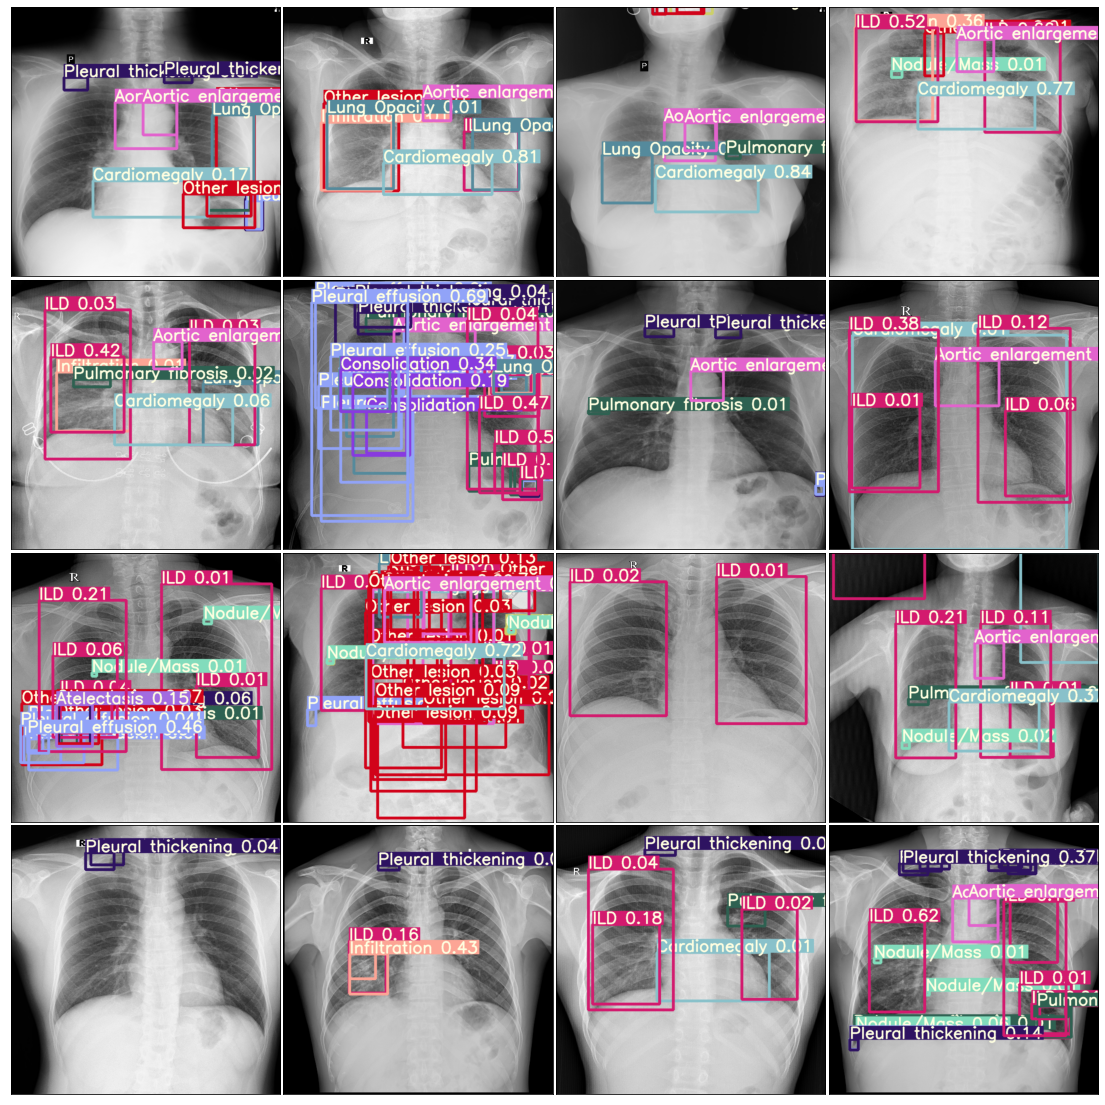

100%|██████████| 16/16 [00:00<00:00, 121.46it/s]


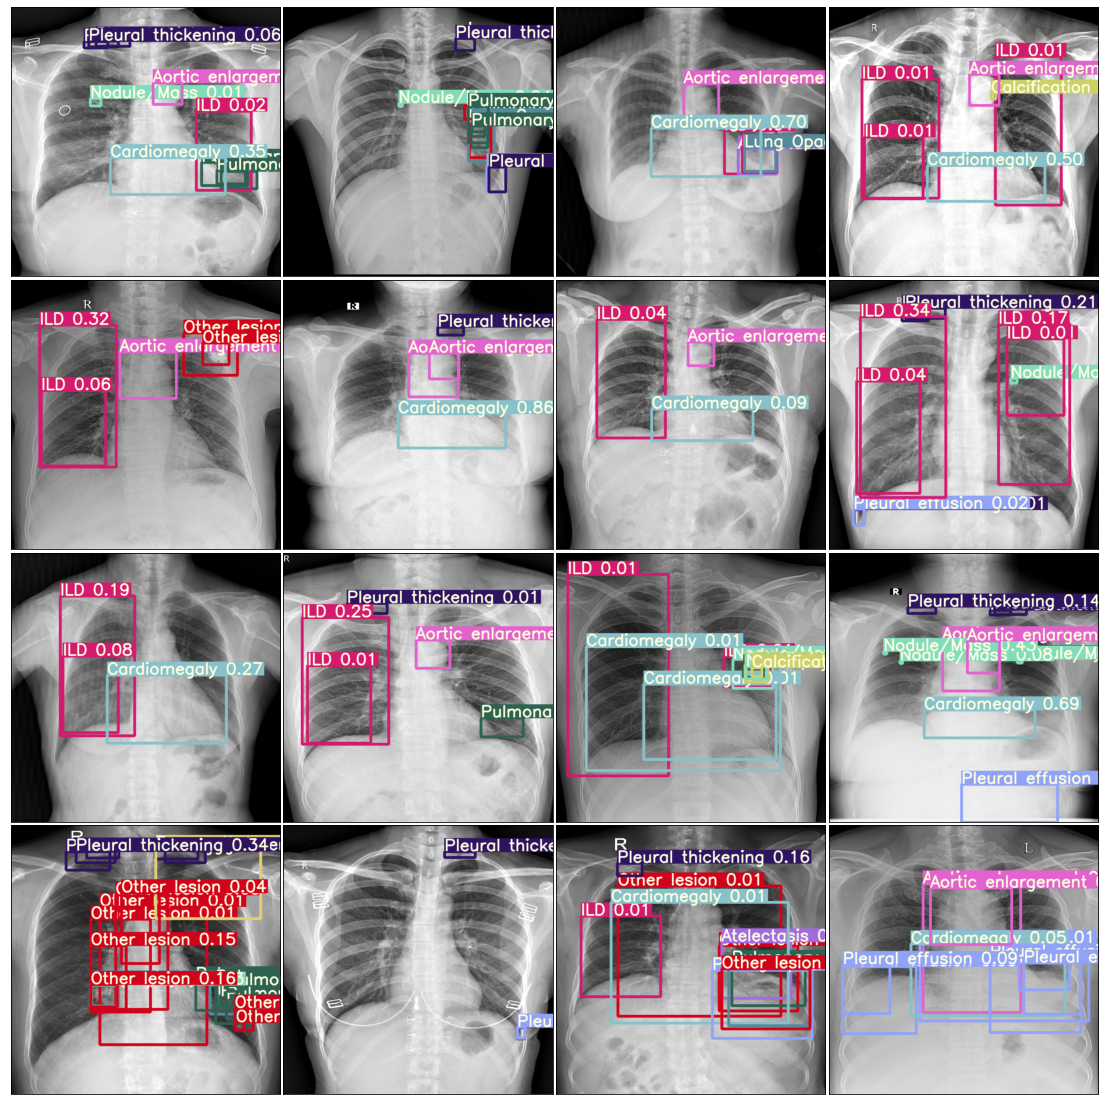

100%|██████████| 16/16 [00:00<00:00, 130.10it/s]


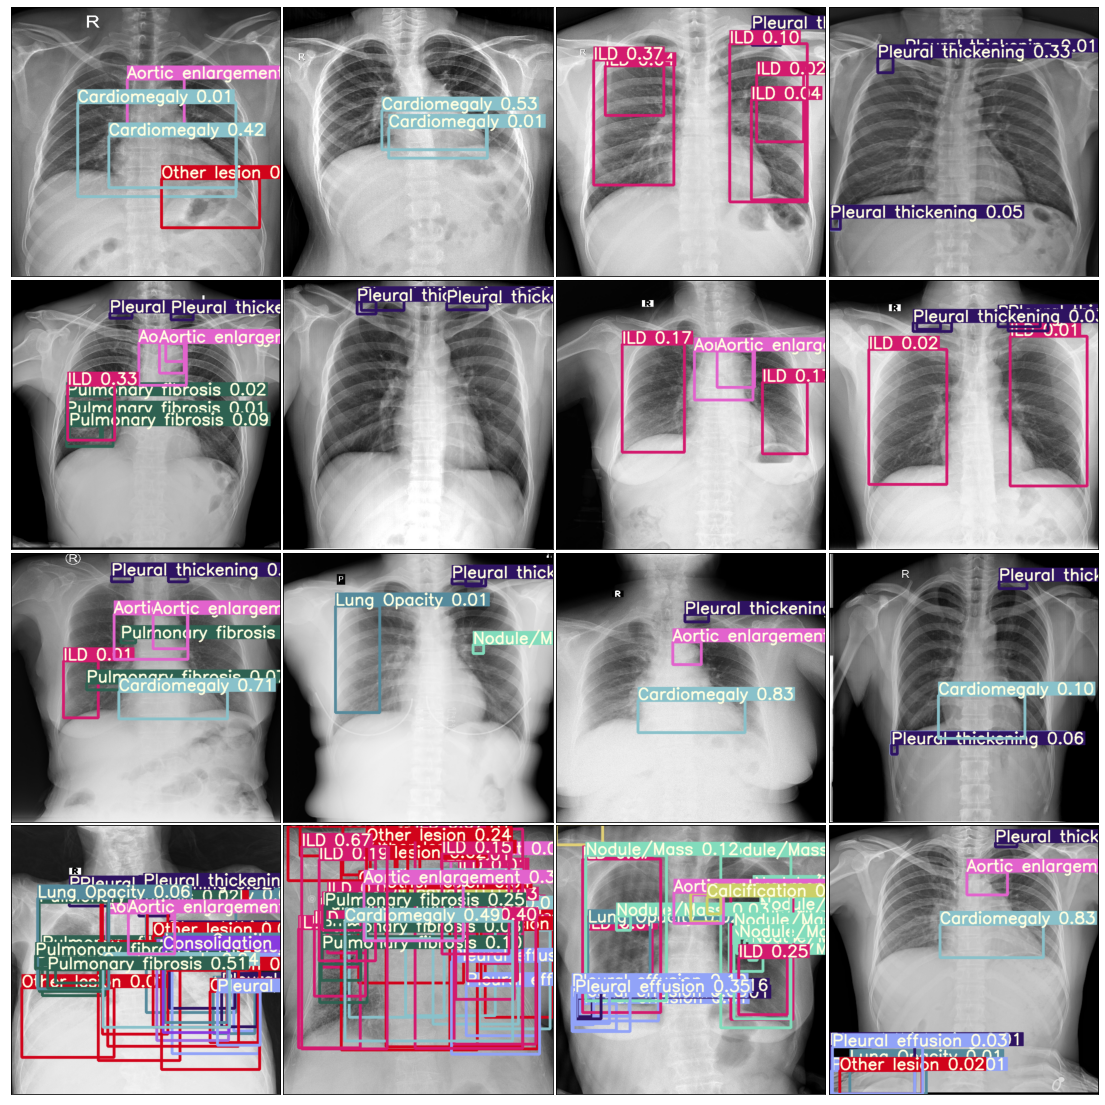

In [27]:
plot_sample_images()

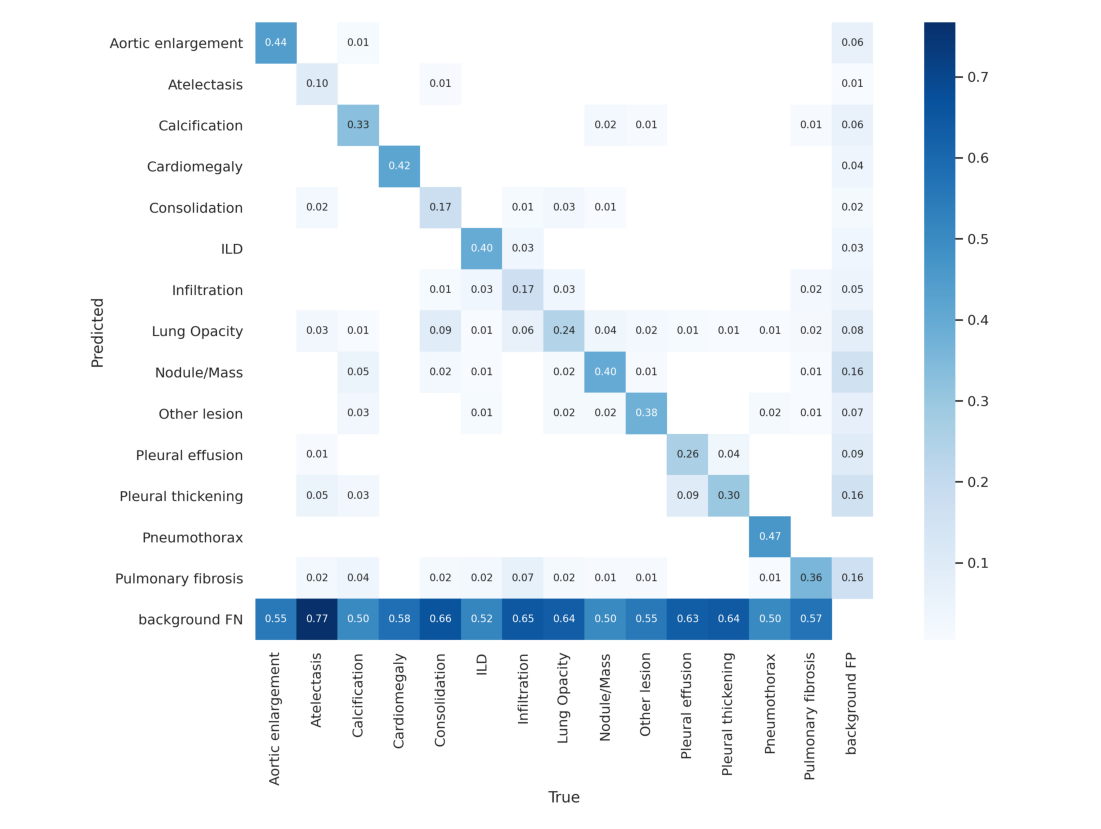

In [28]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));

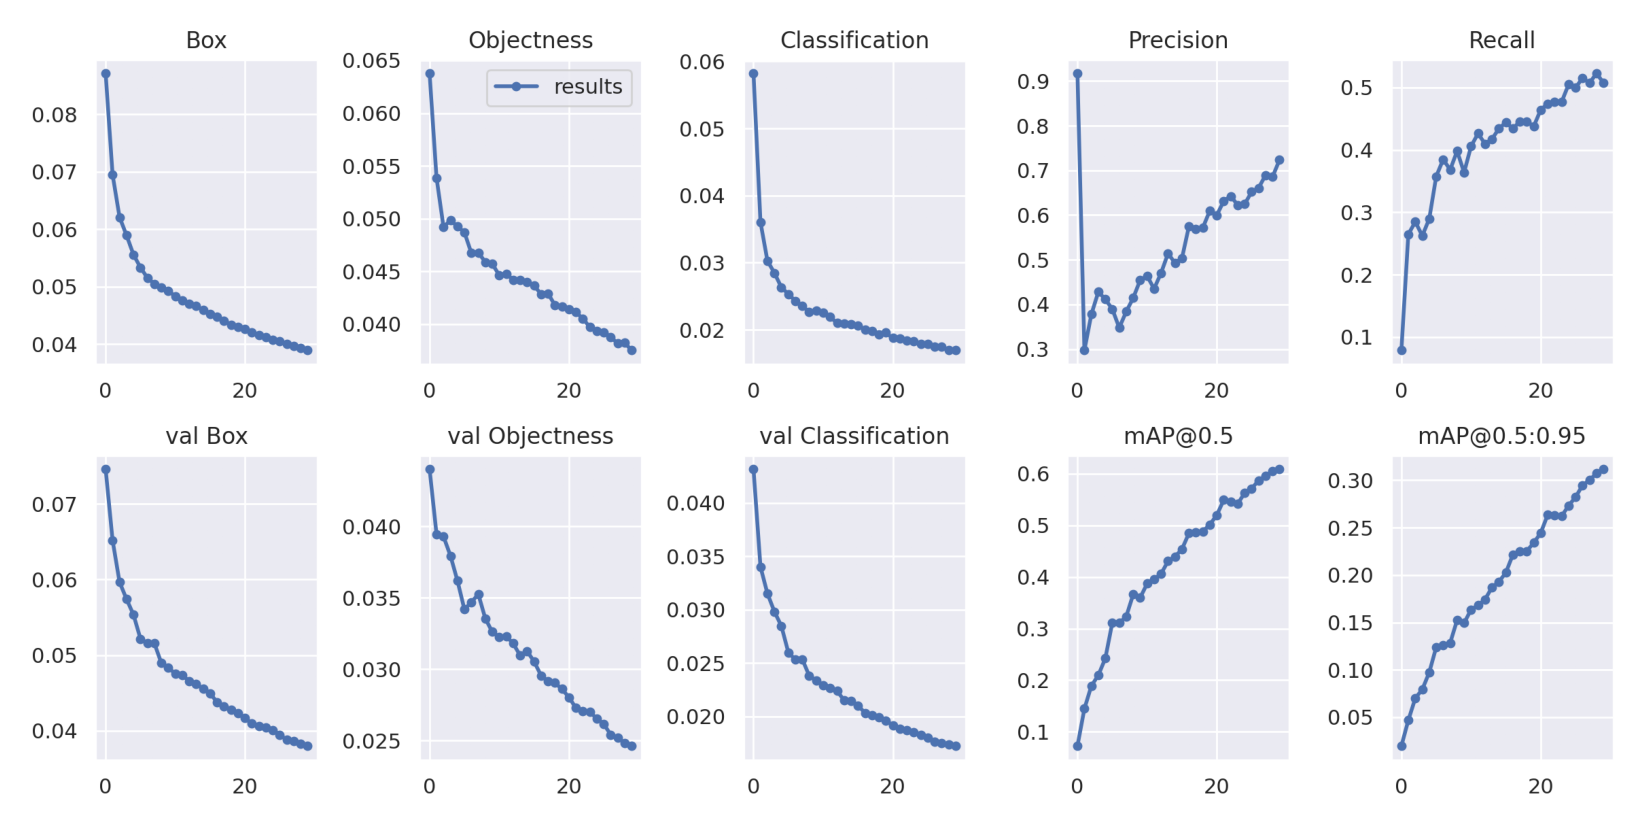

In [29]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'));

In [30]:
!pwd

/kaggle/working/yolov5


In [31]:
# load yolo submission
yolo = pd.read_csv('../submission_3.csv')
effnetb6 = pd.read_csv('/kaggle/input/vinbigdata-2class-prediction/2-cls test pred.csv') # AUC:0.98
pred = pd.merge(yolo, effnetb6, on = 'image_id', how = 'left')
low_thr  = 0.08
high_thr = 0.95

In [32]:
def filter_2cls(row, low_thr=low_thr, high_thr=high_thr):
    prob = row['target']
    if prob<low_thr:
        ## Less chance of having any disease
        row['PredictionString'] = '14 1 0 0 1 1'
    elif low_thr<=prob<high_thr:
        ## More change of having any diesease
        row['PredictionString']+=f' 14 {prob} 0 0 1 1'
    elif high_thr<=prob:
        ## Good chance of having any disease so believe in object detection model
        row['PredictionString'] = row['PredictionString']
    else:
        raise ValueError('Prediction must be from [0-1]')
    return row

In [33]:
sub = pred.apply(filter_2cls, axis=1)
sub[['image_id', 'PredictionString']].to_csv('../submission.csv',index = False)